# Libs

In [2]:
import geopandas as gpd
from fiona.crs import from_epsg
import pandas as pd

import numpy as np
from scipy.spatial import distance_matrix

from pathlib import Path
x
from contextlib import redirect_stdout
from io import StringIO
s=StringIO()

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

import os
import re

import ot

from sklearn.preprocessing import MinMaxScaler

from collections import defaultdict

import folium
from folium.map import *
from folium import plugins
from folium.plugins import MeasureControl
from folium.plugins import FloatImage
from folium.features import RegularPolygonMarker, Choropleth
from folium.vector_layers import Polygon

# Params

In [3]:
DATA_PATH = Path("." ) / ".." / "Data" 
os.listdir(DATA_PATH)

['shpMtlDAAgePyramid',
 'QuebecNeighbourhoods',
 'MontrealNeighbourhoods',
 'shpQcDAAgePyramid']

In [50]:
np.random.seed(1)

# Read in the neighbourhood shp file 

In [4]:
dfNeigh = gpd.read_file( DATA_PATH / "QuebecNeighbourhoods" / "vdq-quartier.shp" )

In [5]:
dfGeo = gpd.read_file( DATA_PATH / "shpQcDAAgePyramid" / "shpQcDAAgePyramid.shp" )
print(dfGeo.columns)
dfGeo.head(2)

Index(['ShapeAr', 'Type', 'Dwllngs', 'Hoshlds', 'GeoUID', 'Popultn', 'CD_UID',
       'CSD_UID', 'CT_UID', 'CMA_UID', 'ReginNm', 'Ar(skm)', '0_4', '5_9',
       '10_14', '15_19', '20_24', '25_29', '30_34', '35_39', '40_44', '45_49',
       '50_54', '55_59', '60_64', '65_69', '70_74', '75_79', '80_84', '85_89',
       '90_94', '95_99', '100_+', 'ID', 'NOM', 'SUPERFI', 'PERIMET',
       'geometry'],
      dtype='object')


ShapeAr Type  Dwllngs  Hoshlds    GeoUID  Popultn CD_UID  CSD_UID  \
0  0.03739   DA      390      367  24230282      578   2423  2423027   
1  0.17787   DA      364      361  24230583      584   2423  2423027   

       CT_UID CMA_UID  ... 80_84  85_89  90_94  95_99  100_+    ID  \
0  4210011.00   24421  ...  20.0    5.0    0.0    0.0    0.0  31.0   
1  4210113.01   24421  ...  40.0   30.0    0.0    0.0    0.0  18.0   

                    NOM     SUPERFI  PERIMET  \
0         Saint-Sauveur  3974715.39  14978.5   
1  Pointe-de-Sainte-Foy  4251524.43  12888.9   

                                            geometry  
0  POLYGON ((-71.2382347648 46.80867905162, -71.2...  
1  POLYGON ((-71.31686364601001 46.76408804561, -...  

[2 rows x 38 columns]

# Data inspection + cleaning

In [6]:
dfGeo.plot()

In [7]:
## Select age columns

listAgeCols = [ "0_4",
                   "5_9" ,
                   "10_14",
                    "15_19" ,
                   "20_24"   ,
                   "25_29", 
                    "30_34"   ,
                   "35_39" ,
                   "40_44" ,
                    "45_49"  ,
                    "50_54" ,
                   "55_59"  ,
                   "60_64"   ,
                    "65_69",
                   "70_74" ,
                   "75_79"     ,
                   "80_84"    ,
                   "85_89"  ,
                    "90_94"    ,
                   "95_99"  ,
                   "100_+"
              ]
dfGeo[listAgeCols].head(2)

0_4   5_9  10_14  15_19  20_24  25_29  30_34  35_39  40_44  45_49  ...  \
0  20.0  10.0   20.0   15.0   50.0   85.0   65.0   60.0   20.0   35.0  ...   
1  20.0  20.0   15.0   15.0   15.0   30.0   15.0   20.0   20.0   15.0  ...   

   55_59  60_64  65_69  70_74  75_79  80_84  85_89  90_94  95_99  100_+  
0   30.0   35.0   25.0   15.0   15.0   20.0    5.0    0.0    0.0    0.0  
1   50.0   55.0   60.0   65.0   50.0   40.0   30.0    0.0    0.0    0.0  

[2 rows x 21 columns]

In [8]:
## Drop rows with missing values

dfGeoNoNull = dfGeo.dropna()
print(dfGeoNoNull.shape)
dfGeoNoNull.head(2)

(879, 38)


ShapeAr Type  Dwllngs  Hoshlds    GeoUID  Popultn CD_UID  CSD_UID  \
0  0.03739   DA      390      367  24230282      578   2423  2423027   
1  0.17787   DA      364      361  24230583      584   2423  2423027   

       CT_UID CMA_UID  ... 80_84  85_89  90_94  95_99  100_+    ID  \
0  4210011.00   24421  ...  20.0    5.0    0.0    0.0    0.0  31.0   
1  4210113.01   24421  ...  40.0   30.0    0.0    0.0    0.0  18.0   

                    NOM     SUPERFI  PERIMET  \
0         Saint-Sauveur  3974715.39  14978.5   
1  Pointe-de-Sainte-Foy  4251524.43  12888.9   

                                            geometry  
0  POLYGON ((-71.2382347648 46.80867905162, -71.2...  
1  POLYGON ((-71.31686364601001 46.76408804561, -...  

[2 rows x 38 columns]

In [61]:
np.all( abs( dfGeoNoNullNorm.div( dfGeoNoNullNorm.sum() ).sum() -1 ) < 10**-4 )

True

# Compute city-wide barycenters (using DAs as the most granular atom)

## Compute the barycenter with the usual euclidean distance

In [11]:
#pd.DataFrame( dfGeoNoNull[listAgeCols].mean(axis=0)).T # alternative and arguably simpler way to compute the average
dfGeoNoNull["const"] = [1] * dfGeoNoNull.shape[0]
dfAgeOverall = dfGeoNoNull.groupby("const")[listAgeCols].agg( "mean")
dfAgeOverall

/home/charles/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0_4        5_9      10_14      15_19      20_24      25_29  \
const                                                                     
1      30.125142  29.783845  25.654152  27.263936  41.569966  43.634812   

           30_34      35_39      40_44     45_49  ...      55_59      60_64  \
const                                             ...                         
1      40.858931  40.938567  34.300341  34.40273  ...  46.353811  42.730375   

          65_69      70_74      75_79      80_84      85_89     90_94  \
const                                                                   
1      38.94198  31.279863  21.399317  15.881684  10.546075  3.589306   

          95_99    100_+  
const                     
1      1.200228  0.16496  

[1 rows x 21 columns]

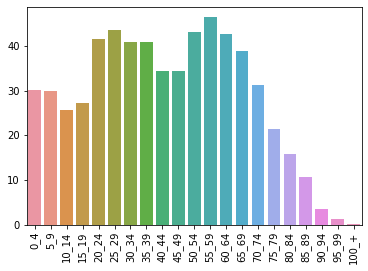

In [12]:
ax=sns.barplot( x=dfAgeOverall.columns, y=dfAgeOverall.iloc[0,:].values)
_ = ax.set_xticklabels(labels= dfAgeOverall.columns, rotation=90)

# Compare with the wasserstein barycenter

In [14]:
## First, compute the distance (L_2 - euclidean - or any l_p since we are in 1D) between the age groups

In [15]:
#Get the first integer preceding "_" so 0_5 -> 5 and 100_mroe -> 100
listIntsAge = np.array([ int(re.match("\d+(?=_)", s).group(0)) for s in listAgeCols ] )
listIntsAge=listIntsAge.reshape(-1,1) #reshape into a column vector for the dist computation
print(listIntsAge.shape)
listIntsAge

(21, 1)


array([[  0],
       [  5],
       [ 10],
       [ 15],
       [ 20],
       [ 25],
       [ 30],
       [ 35],
       [ 40],
       [ 45],
       [ 50],
       [ 55],
       [ 60],
       [ 65],
       [ 70],
       [ 75],
       [ 80],
       [ 85],
       [ 90],
       [ 95],
       [100]])

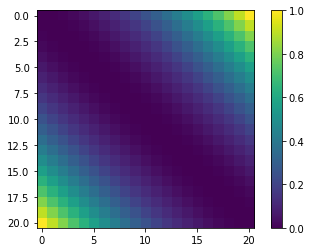

In [16]:
distMatrix = distance_matrix(listIntsAge,listIntsAge)
distMatrix.shape


#Square to that d(5,10) = 5**2 
#l2 norm
distMatrix=distMatrix**2

#Normalize in the hope of avoiding numerical issues
distMatrix=distMatrix/np.max(distMatrix)

plt.imshow(distMatrix)
plt.colorbar()



In [17]:
dfGeoNoNull[listAgeCols]

0_4   5_9  10_14  15_19  20_24  25_29  30_34  35_39  40_44  45_49  ...  \
0    20.0  10.0   20.0   15.0   50.0   85.0   65.0   60.0   20.0   35.0  ...   
1    20.0  20.0   15.0   15.0   15.0   30.0   15.0   20.0   20.0   15.0  ...   
2    25.0  25.0   10.0   15.0   30.0   15.0   30.0   20.0   15.0   20.0  ...   
3    20.0  25.0   10.0   20.0   20.0   20.0   15.0   30.0   25.0   20.0  ...   
4    30.0  25.0   25.0   20.0   30.0   30.0   25.0   40.0   35.0   25.0  ...   
..    ...   ...    ...    ...    ...    ...    ...    ...    ...    ...  ...   
878  25.0  20.0   35.0   30.0   25.0   20.0   25.0   20.0   40.0   30.0  ...   
879  25.0  25.0   20.0   25.0   40.0   30.0   35.0   20.0   20.0   35.0  ...   
880  15.0  30.0   15.0   45.0   35.0   30.0   30.0   35.0   20.0   35.0  ...   
881  20.0  25.0   35.0   20.0   25.0   10.0   15.0   20.0   30.0   15.0  ...   
882  30.0  35.0   20.0   20.0   20.0   25.0   25.0   50.0   20.0   25.0  ...   

     55_59  60_64  65_69  70_74  75_79  80_84  85_89  90_94  95_99  100_+  
0     30.0   35.0   25.0   15.0   15.0   20.0    5.0    0.0    0.0    0.0  
1     50.0   55.0   60.0   65.0   50.0   40.0   30.0    0.0    0.0    0.0  
2     50.0   30.0   30.0   15.0    5.0    5.0    0.0    0.0    0.0    0.0  
3     35.0   25.0   50.0   50.0   10.0    5.0    5.0    0.0    0.0    0.0  
4     45.0   45.0   35.0   35.0   15.0   20.0   15.0    0.0    0.0    0.0  
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  
878   55.0   45.0   40.0   25.0   25.0   10.0    5.0    0.0    0.0    0.0  
879   40.0   30.0   25.0   20.0   20.0   25.0    5.0    0.0    5.0    0.0  
880   55.0   60.0   60.0   50.0   45.0   20.0    5.0    0.0    0.0    0.0  
881   35.0   45.0   35.0   20.0   10.0    0.0    0.0    0.0    0.0    0.0  
882   40.0   30.0   30.0   20.0   15.0   10.0    0.0    0.0    0.0    0.0  

[879 rows x 21 columns]

In [18]:
## Normalize accross rows
#scaler= MinMaxScaler( )
#dfGeoNoNullNorm = pd.DataFrame( scaler.fit_transform(dfGeoNoNull[listAgeCols].copy()), columns=listAgeCols )
dfGeoNoNullNorm = dfGeoNoNull[listAgeCols ].copy()

dfGeoNoNullNorm=dfGeoNoNullNorm.div( dfGeoNoNullNorm.sum(axis=1), axis=0)

print( dfGeoNoNullNorm.shape )
dfGeoNoNullNorm.head(2)

(879, 21)


0_4       5_9     10_14     15_19     20_24     25_29     30_34  \
0  0.035714  0.017857  0.035714  0.026786  0.089286  0.151786  0.116071   
1  0.035714  0.035714  0.026786  0.026786  0.026786  0.053571  0.026786   

      35_39     40_44     45_49  ...     55_59     60_64     65_69     70_74  \
0  0.107143  0.035714  0.062500  ...  0.053571  0.062500  0.044643  0.026786   
1  0.035714  0.035714  0.026786  ...  0.089286  0.098214  0.107143  0.116071   

      75_79     80_84     85_89  90_94  95_99  100_+  
0  0.026786  0.035714  0.008929    0.0    0.0    0.0  
1  0.089286  0.071429  0.053571    0.0    0.0    0.0  

[2 rows x 21 columns]

In [19]:
dfGeoCpy = dfGeoNoNullNorm.copy()
dfGeoCpy["const"] = [1] * dfGeoCpy.shape[0]
dfNormMean=dfGeoCpy.groupby("const").agg("mean")


In [20]:
reg = 1e-1
numDistr=dfGeoNoNullNorm.T.shape[1]
weights=[1/numDistr] * numDistr
bary_wass = ot.bregman.barycenter(dfGeoNoNullNorm.T ,
                                  distMatrix,
                                  reg, 
                                  weights=weights,
                                  method="sinkhorn",
                                  numItermax = 300,
                                  verbose=True)
bary_wass

    1|7.748125e-02|
   11|3.857207e-05|


array([0.03782569, 0.04393392, 0.04965391, 0.05475563, 0.05906981,
       0.06248408, 0.06492587, 0.06634174, 0.06668294, 0.06590399,
       0.06397474, 0.06090173, 0.0567507 , 0.05166194, 0.04585221,
       0.03960079, 0.03322141, 0.02702615, 0.02128873, 0.01621541,
       0.01192862])

In [21]:
dfGeoNoNullNorm.head(2)

0_4       5_9     10_14     15_19     20_24     25_29     30_34  \
0  0.035714  0.017857  0.035714  0.026786  0.089286  0.151786  0.116071   
1  0.035714  0.035714  0.026786  0.026786  0.026786  0.053571  0.026786   

      35_39     40_44     45_49  ...     55_59     60_64     65_69     70_74  \
0  0.107143  0.035714  0.062500  ...  0.053571  0.062500  0.044643  0.026786   
1  0.035714  0.035714  0.026786  ...  0.089286  0.098214  0.107143  0.116071   

      75_79     80_84     85_89  90_94  95_99  100_+  
0  0.026786  0.035714  0.008929    0.0    0.0    0.0  
1  0.089286  0.071429  0.053571    0.0    0.0    0.0  

[2 rows x 21 columns]

In [22]:
f=plt.figure(figsize=(15,5))
maxY=max(max(bary_wass), max(dfNormMean.iloc[0,:].values))

plt.subplot(1,2,1)
plt.ylim(0,maxY)
ax=sns.barplot( x=dfAgeOverall.columns, y=bary_wass)
ax.set_title("Wasserstein barycenter for age pyramid distribution\nUsing all Qc city DAs\nApproximate solution\n\n\n")
_ = ax.set_xticklabels(labels= dfAgeOverall.columns, rotation=90)


plt.subplot(1,2,2)
plt.ylim(0,maxY)
ax=sns.barplot( x=dfAgeOverall.columns, y=dfNormMean.iloc[0,:].values)
ax.set_title("Average age pyramid distribution\nUsing all Qc city DAs\n\n\n\n")
_ = ax.set_xticklabels(labels= dfAgeOverall.columns, rotation=90)

_ = f.suptitle("Age pyramid barycenters under different distances")


f.savefig( DATA_PATH /   ".."/ "Figures" / "qcOverallWassVsEuclidean.png")
 
 

# Illustrate difference with standard euclidean distance

## Take the DAs with the most populous old and young cohorts

In [23]:
oldColumns=['80_84', '85_89', '90_94', '95_99', '100_+']
dfGeoCpy=dfGeoNoNullNorm.copy()
dfGeoCpy["oldPop"] = np.sum(dfGeoCpy[ oldColumns ] ,axis=1)
dfGeoCpy.head()
oldestDAIdx=np.argmax(dfGeoCpy["oldPop"].values)
oldestDAIdx, dfGeoCpy.iloc[oldestDAIdx ,:]

(844, 0_4       0.017544
 5_9       0.017544
 10_14     0.008772
 15_19     0.008772
 20_24     0.021930
 25_29     0.030702
 30_34     0.017544
 35_39     0.026316
 40_44     0.021930
 45_49     0.021930
 50_54     0.017544
 55_59     0.030702
 60_64     0.035088
 65_69     0.030702
 70_74     0.087719
 75_79     0.105263
 80_84     0.210526
 85_89     0.192982
 90_94     0.065789
 95_99     0.030702
 100_+     0.000000
 oldPop    0.500000
 Name: 848, dtype: float64)

In [24]:
youngColumns=['0_4', '5_9', '10_14', '15_19', '20_24']
dfGeoCpy["youngPop"] = np.sum(dfGeoCpy[ youngColumns ] ,axis=1)
dfGeoCpy.head()
youngestDAIdx=np.argmax(dfGeoCpy["youngPop"].values)
youngestDAIdx, dfGeoCpy.iloc[youngestDAIdx,: ]


(438, 0_4         0.008772
 5_9         0.008772
 10_14       0.000000
 15_19       0.087719
 20_24       0.570175
 25_29       0.210526
 30_34       0.043860
 35_39       0.026316
 40_44       0.000000
 45_49       0.017544
 50_54       0.008772
 55_59       0.000000
 60_64       0.008772
 65_69       0.000000
 70_74       0.008772
 75_79       0.000000
 80_84       0.000000
 85_89       0.000000
 90_94       0.000000
 95_99       0.000000
 100_+       0.000000
 oldPop      0.000000
 youngPop    0.675439
 Name: 438, dtype: float64)

In [25]:
## Wass barycenter on the 2 extreme age pyramids
bary_wassExtremes = ot.bregman.barycenter(dfGeoNoNullNorm.iloc[ [oldestDAIdx,youngestDAIdx], : ].T,
                                  distMatrix,
                                  reg, 
                                  weights=[0.5,0.5],
                                  method="sinkhorn",
                                  numItermax = 300,
                                  verbose=True)

    1|2.178312e-01|
   11|2.878431e-07|


In [26]:
## Wass barycenter on the 2 extreme age pyramids
bary_wassExtremesLP = ot.lp.barycenter(dfGeoNoNullNorm.iloc[ [oldestDAIdx,youngestDAIdx], : ].T.values,
                                  distMatrix)

In [27]:
## Average - mixture


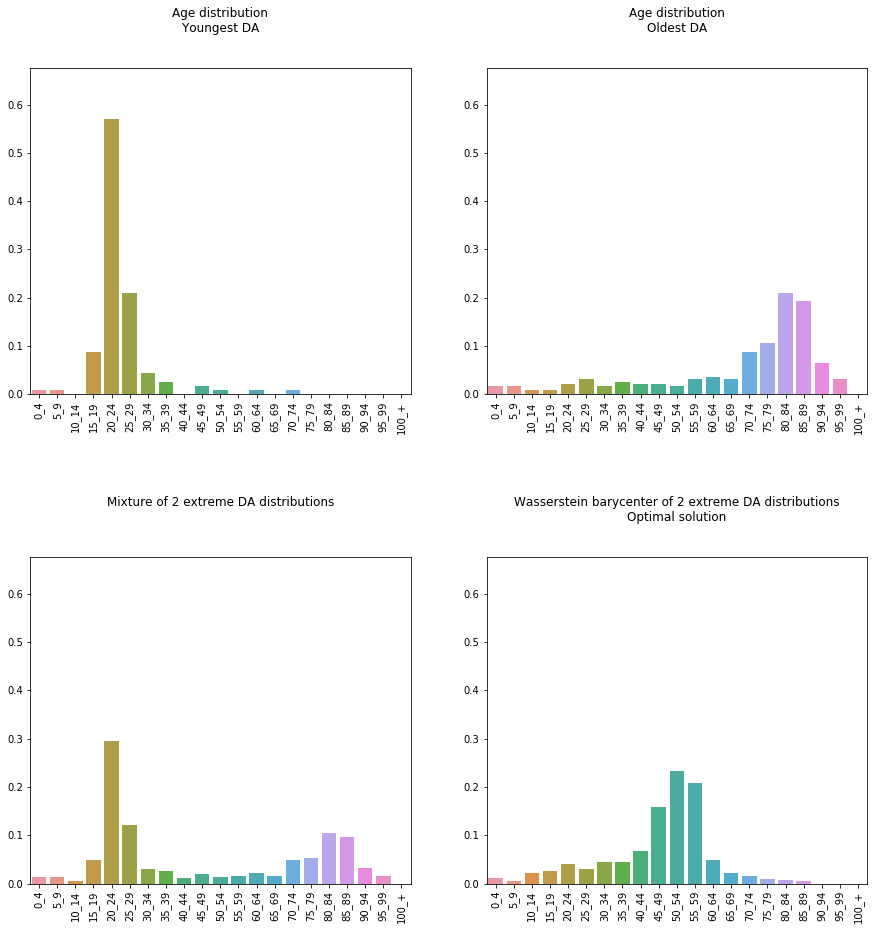

In [28]:
f=plt.figure(figsize=(15,15))
minY=max(max( dfGeoCpy.iloc[youngestDAIdx,: ]), max( dfGeoCpy.iloc[oldestDAIdx,: ]))

plt.subplot(2,2,1)
plt.ylim(0,minY)
ax=sns.barplot( x=dfAgeOverall.columns, y=dfGeoNoNullNorm.iloc[youngestDAIdx,:].values)
ax.set_title("Age distribution\nYoungest DA\n\n")
_ = ax.set_xticklabels(labels= dfAgeOverall.columns, rotation=90)


plt.subplot(2,2,2)
plt.ylim(0,minY)
ax=sns.barplot( x=dfAgeOverall.columns, y=dfGeoNoNullNorm.iloc[oldestDAIdx,:].values)
ax.set_title("Age distribution\nOldest DA\n\n")
_ = ax.set_xticklabels(labels= dfAgeOverall.columns, rotation=90)


plt.subplot(2,2,3)
plt.ylim(0,minY)
ax=sns.barplot( x=dfAgeOverall.columns, y=dfGeoNoNullNorm.iloc[ [oldestDAIdx,youngestDAIdx], : ].mean(axis=0).values)
ax.set_title("Mixture of 2 extreme DA distributions\n\n\n")
_ = ax.set_xticklabels(labels= dfAgeOverall.columns, rotation=90)


plt.subplot(2,2,4)
plt.ylim(0,minY)
ax=sns.barplot( x=dfAgeOverall.columns, y=bary_wassExtremesLP)
ax.set_title("Wasserstein barycenter of 2 extreme DA distributions\nOptimal solution\n\n")
_ = ax.set_xticklabels(labels= dfAgeOverall.columns, rotation=90)


plt.subplots_adjust(hspace=0.5)



_ = f.suptitle("")


f.savefig( DATA_PATH /   ".."/ "Figures" / "qcHistDAExtreme.png")
 

## Visualize wass distance between barycenter and different (extreme) DA age distributions

In [29]:
listOptTransport=defaultdict(np.array)
listTitles = defaultdict(str)
listCosts= defaultdict(float)

listOptTransport[0] =ot.emd(bary_wass,
                      np.ascontiguousarray(dfGeoNoNullNorm.iloc[youngestDAIdx,:].values),
                       distMatrix)

# Matrix norm of hadamard (element wise) product
listCosts[0]= np.sum( listOptTransport[0][:]* distMatrix[:]) 
listTitles[0] = f"Youngest DA - Wasserstein barycenter\nTotal Wasserstein distance: {listCosts[0]:.2f}"



listOptTransport[1] = ot.emd(bary_wass,
                      np.ascontiguousarray(dfGeoNoNullNorm.iloc[oldestDAIdx,:].values),
                       distMatrix)

listCosts[1]= np.sum( listOptTransport[1][:]* distMatrix[:]) 
listTitles[1] = f"Oldest DA - Wasserstein barycenter\nTotal Wasserstein distance: {listCosts[1]:.2f}"




listOptTransport[2] = ot.emd(bary_wass,
                  dfGeoNoNullNorm.iloc[ [oldestDAIdx,youngestDAIdx], : ].mean(axis=0).values,
                   distMatrix)
listCosts[2] = np.sum( listOptTransport[2][:]* distMatrix[:])
listTitles[2] = f"Mixture - Wasserstein barycenter\nTotal Wasserstein distance: {listCosts[2]:.2f}"


In [30]:
city="Quebec City"

f=plt.figure(figsize=(12,12)) 
 
for i in range(3): 
    ax=plt.subplot(2,2,i+1)
    plt.imshow( listOptTransport[i] )
    ax.set_title(listTitles[i])
    plt.colorbar()

_ = plt.suptitle(f"Wasserstein distances and optimal transport plans - {city}", fontsize=20)

f.savefig( DATA_PATH /".."/ "Figures" / "qcOptTransportDAExtreme.png")

## Plot the 2 DA extremums (oldest and youngest)

In [32]:
def getCol(i):
    if i == youngestDAIdx :
        c="red"
    elif i == oldestDAIdx:
        c="blue"
    else:
        c="grey"
        
    return c

cols=[ getCol(i) for i in range(dfGeo.shape[0]) ]


In [33]:
dfGeoNoNullNorm["isYoungest"]=range(dfGeoNoNullNorm.shape[0]) == youngestDAIdx 
dfGeoNoNullNorm["isOldest"]=range(dfGeoNoNullNorm.shape[0]) == oldestDAIdx 

In [34]:
print( np.where( dfGeoNoNullNorm["isYoungest"] ), youngestDAIdx, 
np.where( dfGeoNoNullNorm["isOldest"] ), oldestDAIdx )

(array([438]),) 438 (array([844]),) 844


In [35]:
## Reproject using conformal Albers for Qc

#Alternatively, could use this equal area mapping for Canada
#crsString="+proj=aea +lat_1=50 +lat_2=70 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"
 
dfNeigh=dfNeigh.to_crs(epsg=32198)
dfGeoNoNull=dfGeoNoNull.to_crs(epsg=32198)

In [36]:
## Determine the neighbourhood of the extreme DAs

daNeigh=defaultdict(int)

for k, r in dfGeoNoNull.iterrows():
    daNeigh[k] = np.where( dfNeigh["geometry"].contains( r["geometry"].centroid ) )  

In [37]:
dfGeoNoNullNorm.columns

Index(['0_4', '5_9', '10_14', '15_19', '20_24', '25_29', '30_34', '35_39',
       '40_44', '45_49', '50_54', '55_59', '60_64', '65_69', '70_74', '75_79',
       '80_84', '85_89', '90_94', '95_99', '100_+', 'isYoungest', 'isOldest'],
      dtype='object')

## Plot the DAs and the neighbourhoods

/home/charles/anaconda3/envs/py37/lib/python3.7/site-packages/geopandas/plotting.py:393: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


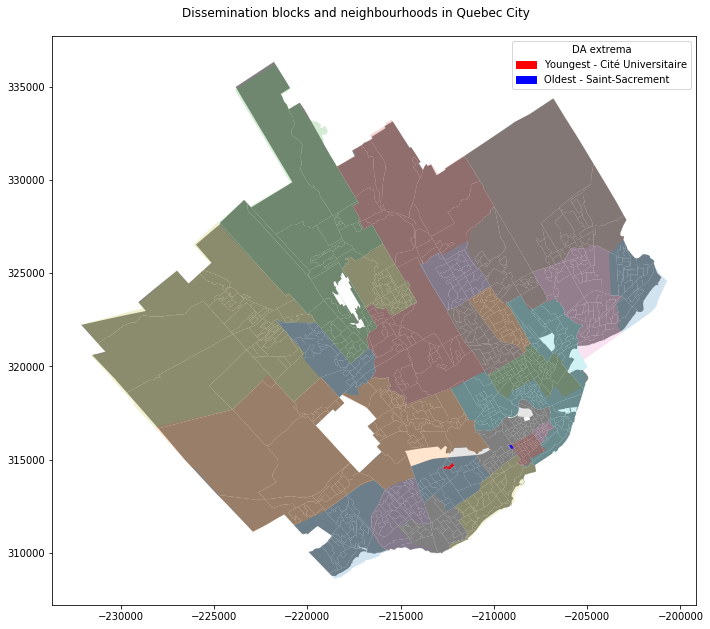

In [38]:

f,ax=plt.subplots(figsize=(10,15))
_ = f.suptitle("Dissemination blocks and neighbourhoods in Quebec City")


youngNameNeigh=dfGeoNoNull.iloc[youngestDAIdx ]["NOM"]
oldNameneigh=dfGeoNoNull.iloc[oldestDAIdx]["NOM"]
strList=[f"Youngest - {youngNameNeigh}", 
         f"Oldest - {oldNameneigh}"]

rgbCols = [mcolors.to_rgba("red"),mcolors.to_rgba("blue")]
listLegendHandles=[]

for k,l in enumerate(strList):
    listLegendHandles.append(mpatches.Patch(color=rgbCols[k],  
                                            label=l))

ax.legend(title="DA extrema",
               handles=listLegendHandles,
               loc="best")


dfGeoNoNull.plot( column="isYoungest", categorical=True, legend=True, color=cols,ax=ax)
dfNeigh.plot(column="NOM",  categorical=True, ax=ax, alpha=0.2)



f.tight_layout(rect=[0, 0.03, 1, 1.35])

f.savefig( DATA_PATH /  ".."/ "Figures" / "qcspatialDAExtreme.png")

## Analyze wass distance by neighbourhood

In [40]:
## Compute the age pyramid by neighbourhood 
dfGeoNoNullCpy=dfGeoNoNull.copy()
dfMeanAgePyrByNeigh = dfGeoNoNullCpy.groupby("NOM")[listAgeCols].agg("mean")
dfMeanAgePyrByNeighNorm = dfMeanAgePyrByNeigh.div(dfMeanAgePyrByNeigh.sum(axis=1),axis=0)
 

    1|4.796419e-02|
   11|2.507999e-05|


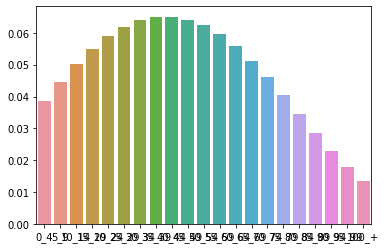

In [41]:
bary_wass_neigh= ot.bregman.barycenter(dfMeanAgePyrByNeighNorm.T.values ,distMatrix,reg,  verbose=True)



sns.barplot(x=dfAgeOverall.columns, y=bary_wass_neigh)


 

In [42]:
## Compute the difference from each neighbourhood to the neigh barycenter   

In [43]:
listOptTransNeigh=defaultdict(np.array)
listCostsNeigh=defaultdict(float)

for i in range(dfMeanAgePyrByNeigh.shape[0]):
    listOptTransNeigh[i]=ot.emd(bary_wass_neigh,
                            np.ascontiguousarray(dfMeanAgePyrByNeighNorm.iloc[i,:].values),
                            distMatrix)
    listCostsNeigh[i] = np.sum( listOptTransNeigh[i][:] * distMatrix[:])
    
        
dfMeanAgePyrByNeighNorm["distToBarycenter"] = list(listCostsNeigh.values())
dfMeanAgePyrByNeighNorm.head()

dfMeanAgePyrByNeighNorm.sort_values("distToBarycenter", inplace=True)


In [44]:
dfMeanAgePyrByNeighNorm.reset_index(inplace=True) 
dfMeanAgePyrByNeighNorm.NOM=pd.Categorical( dfMeanAgePyrByNeighNorm.NOM, categories=[n for n in dfMeanAgePyrByNeighNorm.NOM],ordered=True)


In [45]:
f=plt.figure(figsize=(15,10))

city="Quebec City" 

ax=sns.barplot(x="NOM" , y = "distToBarycenter" , data=dfMeanAgePyrByNeighNorm, order=dfMeanAgePyrByNeighNorm["NOM"]) 
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
ax.set(xlabel="Neighbourhood", 
       ylabel="Distance from city barycenter"
       )
plt.title(label=f"Age Pyramid Irregularity by Neighbourhood - Wasserstein distance\n{city}", loc="left")

Text(0.0, 1.0, 'Age Pyramid Irregularity by Neighbourhood - Wasserstein distance\nQuebec City')

In [47]:
[dfMeanAgePyrByNeighNorm["NOM"].unique().sort_values()]
dfMeanAgePyrByNeighNorm.loc[dfMeanAgePyrByNeighNorm["NOM"] == "Saint-Jean-Baptiste",][listAgeCols].mean()

0_4      0.029868
5_9      0.022975
10_14    0.020103
15_19    0.018955
20_24    0.084434
25_29    0.129810
30_34    0.094773
35_39    0.078690
40_44    0.054566
45_49    0.044227
50_54    0.053418
55_59    0.063756
60_64    0.076393
65_69    0.067777
70_74    0.045376
75_79    0.028719
80_84    0.029868
85_89    0.028145
90_94    0.018955
95_99    0.008041
100_+    0.001149
dtype: float64

In [48]:
f=plt.figure(figsize=(20,20))
maxY=0.25

    
#The barycenter
sp=plt.subplot(6,6,1)
ax=sns.barplot(  x=dfAgeOverall.columns, y= bary_wass_neigh )
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title(label="Wasserstein barycenter", fontname="DejaVu Sans")
plt.ylim(0,maxY)

    
#Now the rest of the neighourhoods
for k,n in enumerate(dfMeanAgePyrByNeighNorm["NOM"].unique().sort_values()):
    dfMeanAgePyrByNeighNorm[listAgeCols]=dfMeanAgePyrByNeighNorm[listAgeCols].div( dfMeanAgePyrByNeighNorm[listAgeCols].sum(axis=1), axis=0)
    dfSubset = dfMeanAgePyrByNeighNorm.loc[dfMeanAgePyrByNeighNorm["NOM"] == n,]
    sp=plt.subplot(6,6,k+1+1)
    ax=sns.barplot(  x=dfAgeOverall.columns, y= dfSubset[listAgeCols].mean()  )
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.title(label=f"{n}")
    plt.ylim(0,maxY)



plt.subplots_adjust(hspace=0.5)
plt.suptitle(f"Average age distribution\n{city}", fontsize=20 , y=0.93, x=0.5)

Text(0.5, 0.93, 'Average age distribution\nQuebec City')

In [ ]:
## Compute the difference from each DA to barycenter by neighbourhood

In [ ]:
dfByNeigh=dfGeoNoNullCpy.groupby("NOM")['distToBarycenter'].agg("median")

In [ ]:
# Now determine the DA with the most representative age pyramid

In [ ]:
## First get the distance from each DA to the barycenter

In [ ]:
listOptTrans=defaultdict(np.array)
listCosts=defaultdict(float)

for i in range(dfGeoNoNullNorm.shape[0]):
    listOptTrans[i]=ot.emd(bary_wass,
                            np.ascontiguousarray(dfGeoNoNullNorm.iloc[i,:].values),
                            distMatrix)
    listCosts[i] = np.sum( listOptTrans[i][:] * distMatrix[:])
    
        
dfGeoNoNull["distToBarycenter"] = list(listCosts.values())

In [ ]:
sns.distplot( np.array( list(listCosts.values()) ) )

In [ ]:
## Plot distance from barycenter as function of neighbourhood

In [ ]:
from pandas.api.types import CategoricalDtype

dfGeoNoNullCpy=dfGeoNoNull.copy()

dfByNeigh=dfGeoNoNullCpy.groupby("NOM")['distToBarycenter'].agg("median")
dfByNeigh.sort_values(inplace=True)
dfByNeigh.index = dfByNeigh.index.astype(CategoricalDtype( categories = dfByNeigh.index,ordered=True) )
dfByNeigh
dfByNeigh.index

In [ ]:
## Check the distance according to the neighbourhood

dfGeoNoNullCpy["NOM"]=dfGeoNoNullCpy["NOM"].astype(CategoricalDtype( categories = dfByNeigh.index,ordered=True) )
 

In [ ]:
f=plt.figure(figsize=(15,10))

city="Quebec City" 

ax=sns.boxplot(x="NOM" , y = "distToBarycenter", data=dfGeoNoNullCpy) 
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
ax.set(xlabel="Neighbourhood", 
       ylabel="Distance from city barycenter"
       )
plt.title(label=f"Age Pyramid Irregularity by Dissemination Area and Neighbourhood\n{city}", loc="left")

In [ ]:
f=plt.figure(figsize=(20,20))
dfGeoNoNullCpyNorm = dfGeoNoNullCpy.copy()
maxY=0.25

    
#The barycenter
sp=plt.subplot(6,6,1)
ax=sns.barplot(  x=dfAgeOverall.columns, y= bary_wass )
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title(label="Wasserstein barycenter", fontname="DejaVu Sans")
plt.ylim(0,maxY)

    
#Now the rest of the neighourhoods
for k,n in enumerate(dfGeoNoNullCpy["NOM"].unique().sort_values()):
    dfGeoNoNullCpyNorm[listAgeCols]=dfGeoNoNullCpy[listAgeCols].div( dfGeoNoNullCpy[listAgeCols].sum(axis=1), axis=0)
    dfSubset = dfGeoNoNullCpyNorm.loc[dfGeoNoNullCpyNorm["NOM"] == n,]
    sp=plt.subplot(6,6,k+1+1)
    ax=sns.barplot(  x=dfAgeOverall.columns, y= dfSubset[listAgeCols].mean() )
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.title(label=f"{n}")
    plt.ylim(0,maxY)



plt.subplots_adjust(hspace=0.5)
plt.suptitle(f"Average age distribution\n{city}", fontsize=20 , y=0.93, x=0.5)

In [ ]:
quantDist = np.quantile( dfGeoNoNullCpy.distToBarycenter ,q=0.99)
dfExtremeDAs=dfGeoNoNullCpy.loc[ dfGeoNoNullCpy.distToBarycenter >= quantDist, ]
print(dfExtremeDAs.shape)
dfExtremeDAs.NOM = dfExtremeDAs.NOM.cat.remove_unused_categories()
ax=sns.countplot( dfExtremeDAs["NOM"] )
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [ ]:
dfExtremeDAByNeigh=dfExtremeDAs.groupby("NOM")["NOM"].agg("count")
dfExtremeDAByNeighFiltered= dfExtremeDAByNeigh.loc[dfExtremeDAByNeigh>0]
dfCount=pd.DataFrame( dfExtremeDAByNeighFiltered ).rename(columns={"NOM":"count"}).reset_index()
dfCount.NOM=dfCount.NOM.cat.remove_unused_categories()
ax=sns.barplot( x="NOM", y="count", data=dfCount)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [ ]:
f=plt.figure(figsize=(20,20))
dfGeoNoNullCpyNorm = dfGeoNoNullCpy.copy()
maxY=0.25

    
#The barycenter
sp=plt.subplot(4,3,1)
ax=sns.barplot(  x=dfAgeOverall.columns, y= bary_wass )
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title(label="Wasserstein barycenter", fontname="DejaVu Sans")
plt.ylim(0,maxY)

#Normalize and sort by dist to barycenter
dfExtremeDAs[listAgeCols]=dfExtremeDAs[listAgeCols].div( dfExtremeDAs[listAgeCols].sum(axis=1), axis=0)
dfExtremeDAs.sort_values("distToBarycenter",ascending=False,inplace=True)

#Now the rest of the neighourhoods
for k  in range(dfExtremeDAs.shape[0]):

    sp=plt.subplot(4,3,k+1+1)
    ax=sns.barplot(  x=dfAgeOverall.columns, y= dfExtremeDAs.iloc[k][listAgeCols]  )
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.title(label=f"{dfExtremeDAs.iloc[k].NOM}\nWasserstein distance: {dfExtremeDAs.iloc[k].distToBarycenter:.4f}")
    plt.ylim(0,maxY)



plt.subplots_adjust(hspace=0.5)
plt.suptitle(f"Extreme age distribution\nBy dissemination area - {city}", fontsize=20 , y=0.95, x=0.5)

## Compute an approximate avg age by DA using the average of age group 

In [ ]:
dfExtremeDAs[listAgeCols]
avg = [ 2+5*i for i in range(len(listAgeCols)-1)] + [105]
pd.DataFrame( [avg, listAgeCols])

In [ ]:
dictAge= defaultdict(int)
for k in range(dfExtremeDAs.shape[0]):
    dictAge[k]=np.dot(avg, dfExtremeDAs[listAgeCols].iloc[k].values) 
dfExtremeDAs["avgAge"] = list(dictAge.values())

In [ ]:
dfExtremeDAs["avgAge"] 

In [ ]:

#Don't forget to set the crs to 4326 lng,lat
dfExtremeDAs['geometry']=dfExtremeDAs['geometry'].to_crs(epsg=4326)
dfExtremeDAs.crs= from_epsg(4326)

m = folium.Map(location=(46.816170, -71.208504), zoom_start=13,tiles='CartoDBPositron')

 

Choropleth(
    geo_data=dfExtremeDAs,
    name='Distance',
    data=dfExtremeDAs,
    columns=["NOM", 'distToBarycenter'],
    fill_color='Reds',
     key_on="feature.properties.NOM",
    fill_opacity=0.7,
    line_opacity=0.9,
    legend_name='Distance to barycenter',
    highlight=True 
).add_to(m)
 


Choropleth(
    geo_data=dfExtremeDAs,
    name='Average Age',
    data=dfExtremeDAs,
    columns=["NOM", 'avgAge'],  
    fill_color='Blues',
     key_on="feature.properties.NOM",
    fill_opacity=0.7,
    line_opacity=0.9,
    legend_name='Average age in dissemination area',
    highlight=True
).add_to(m)
 

    
#fg = folium.FeatureGroup(name='Dissemination ')

for k  in range(dfExtremeDAs.shape[0]):
    i=dfExtremeDAs.index[k]

    y,x= dfExtremeDAs.geometry[i].exterior.coords.xy
    centy,centx = dfExtremeDAs.geometry[i].centroid.coords.xy
    strPopup=str("<b>" +  dfExtremeDAs.NOM[i]) + "</b>" + "<br>" + \
                "Wassertstein distance : " + f"{dfExtremeDAs.distToBarycenter[i]:.4f}" +  "<br>" + \
                "Average Age: " + f"{dfExtremeDAs.avgAge[i]:.2f}" 
    print(strPopup +  str(centx) + str(centy) )
    #fg.add_child( Polygon(locations=list(zip(x,y)), popup=strPopup) )
    Polygon(locations=list(zip(x,y)), popup=strPopup).add_to(m)
    folium.Marker(location=[centx[0],centy[0]],popup=strPopup).add_to(m)

#m.add_child(fg)

folium.LayerControl(collapsed=False).add_to(m)

with open( Path(".") / ".." / "Html" / 'map.html', 'wb' ) as f:
    m.save(f)
    
    
m
 